In [1]:
from PIL import Image
image = Image.open('./pkm/all/001.png')

In [2]:
image.size

(400, 400)

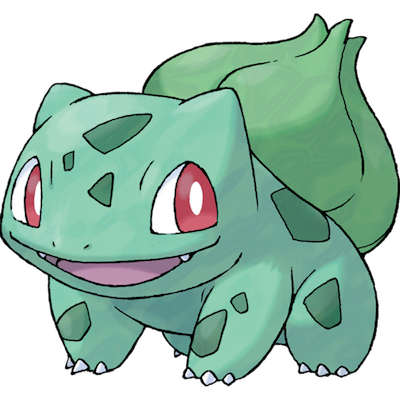

In [3]:
image

In [4]:
from PIL import Image


def append_images(images, direction='horizontal',
                  bg_color=(255,255,255), aligment='center'):
    """
    Appends images in horizontal/vertical direction.

    Args:
        images: List of PIL images
        direction: direction of concatenation, 'horizontal' or 'vertical'
        bg_color: Background color (default: white)
        aligment: alignment mode if images need padding;
           'left', 'right', 'top', 'bottom', or 'center'

    Returns:
        Concatenated image as a new PIL image object.
    """
    widths, heights = zip(*(i.size for i in images))

    if direction=='horizontal':
        new_width = sum(widths)
        new_height = max(heights)
    else:
        new_width = max(widths)
        new_height = sum(heights)

    new_im = Image.new('RGB', (new_width, new_height), color=bg_color)


    offset = 0
    for im in images:
        if direction=='horizontal':
            y = 0
            if aligment == 'center':
                y = int((new_height - im.size[1])/2)
            elif aligment == 'bottom':
                y = new_height - im.size[1]
            new_im.paste(im, (offset, y))
            offset += im.size[0]
        else:
            x = 0
            if aligment == 'center':
                x = int((new_width - im.size[0])/2)
            elif aligment == 'right':
                x = new_width - im.size[0]
            new_im.paste(im, (x, offset))
            offset += im.size[1]

    return new_im

# Settings

In [5]:
%env TF_KERAS = 1
import os
sep_local = os.path.sep

import sys
sys.path.append('..'+sep_local+'..'+sep_local+'..')
print(sep_local)

env: TF_KERAS=1
\


In [6]:
import tensorflow as tf
print(tf.__version__)

2.1.0


# Dataset loading

In [7]:
dataset_name='pokemon'

In [8]:
IMG_DIR = './pkm/'
VAL_PCT = 0
VAL_FORMAT = 'png'

In [9]:
from training.generators.file_image_generator import create_image_lists, get_generators

Using TensorFlow backend.


In [10]:
imgs_list = create_image_lists(
    image_dir=IMG_DIR, 
    validation_pct=VAL_PCT, 
    valid_imgae_formats=VAL_FORMAT
)

  DEBUG    | Looking for images in 'all'


  INFO     | 4 file found


  WARNING  | Folder has less than 20 images, which may cause issues.
..\..\..\training\generators\file_image_generator.py:91: UserWarning: Folder has less than 20 images, which may cause issues.
  warnings.warn(msg)


In [11]:
inputs_shape= IMG_SIZE=(200, 200, 3)
BATCH_SIZE = 4
latent_dim = 100
intermediate_dim = 100

In [12]:
train_gen, test_gen = get_generators(
    images_list=imgs_list, 
    image_dir=IMG_DIR, 
    image_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode=None
)

  INFO     | Found 4 training files


  INFO     | Found 0 validation files


In [13]:
from utils.augmentation.augmentor import operations, do_operation

In [14]:
str(operations[0]())

'Skew'

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2


In [16]:
batch = next(train_gen)
batch = next(train_gen)

In [17]:
_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in batch]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')

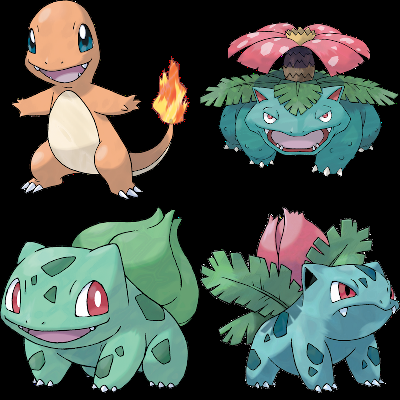

In [18]:
final

operation Skew ===================
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)


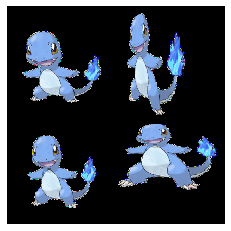

In [19]:
i = 0
_batch = []
for image in [batch[0]]:
    opt = operations[i]()
    print(f"operation {opt} ===================")
    for _ in range(4):
        opt = operations[i]()
        temp = do_operation(opt, image)
        print(temp.shape)
        _batch += [temp]

_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in _batch]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

operation Distort ===================
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)


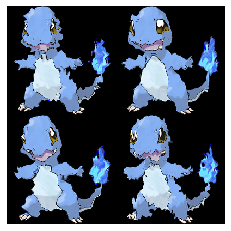

In [20]:
i = 1
_batch = []
for image in [batch[0]]:
    opt = operations[i]()
    print(f"operation {opt} ===================")
    for _ in range(4):
        opt = operations[i]()
        temp = do_operation(opt, image)
        print(temp.shape)
        _batch += [temp]    
    
_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in _batch]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

operation Rotate 285 ===================
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)


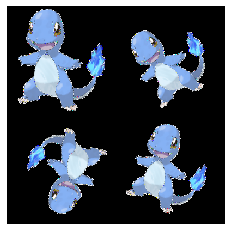

In [21]:
i = 2
_batch = []
for image in [batch[0]]:
    opt = operations[i]()
    print(f"operation {opt} ===================")
    for _ in range(4):
        opt = operations[i]()
        temp = do_operation(opt, image)
        print(temp.shape)
        _batch += [temp]

_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in _batch]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

operation Shear ===================
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)


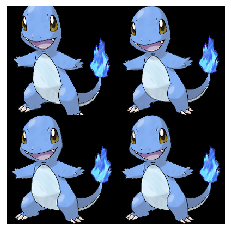

In [22]:
i = 3
_batch = []
for image in [batch[0]]:
    opt = operations[i]()
    print(f"operation {opt} ===================")
    for _ in range(4):
        opt = operations[i]()
        temp = do_operation(opt, image)
        print(temp.shape)
        _batch += [temp]

_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in _batch]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

operation Zoom ===================
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)


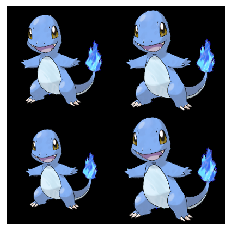

In [23]:
i = 4
_batch = []
for image in [batch[0]]:
    opt = operations[i]()
    print(f"operation {opt} ===================")
    for _ in range(4):
        opt = operations[i]()
        temp = do_operation(opt, image)
        print(temp.shape)
        _batch += [temp]

_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in _batch]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

operation Colorize ===================
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)


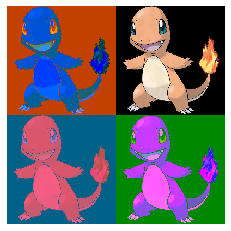

In [24]:
i = 5
_batch = []
for image in [batch[0]]:
    opt = operations[i]()
    print(f"operation {opt} ===================")
    for _ in range(4):
        opt = operations[i]()
        temp = do_operation(opt, image)
        print(temp.shape)
        _batch += [temp]

_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in _batch]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

operation Skitch ===================
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)


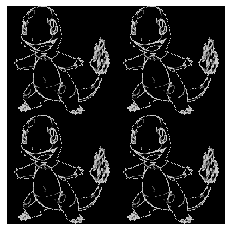

In [25]:
i = 6
_batch = []
for image in [batch[0]]:
    opt = operations[i]()
    print(f"operation {opt} ===================")
    for _ in range(4):
        opt = operations[i]()
        temp = do_operation(opt, image)
        print(temp.shape)
        _batch += [temp]

_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in _batch]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

operation Flip ===================
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)


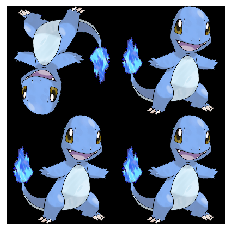

In [26]:
i = 7
_batch = []
for image in [batch[0]]:
    opt = operations[i]()
    print(f"operation {opt} ===================")
    for _ in range(4):
        opt = operations[i]()
        temp = do_operation(opt, image)
        print(temp.shape)
        _batch += [temp]

_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in _batch]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

In [27]:
import random

In [28]:
def batch_augmentor(batch, operation=None):
    if operation is None:
        rn = random.randint(0, len(operations)-1)
        print(operations[rn]())
        operation = operations[rn]()
    return np.array([do_operation(operation, image) for image in batch])


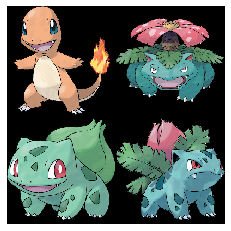

In [29]:
_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in batch]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

Distort


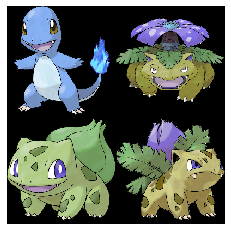

In [30]:
batch_augmented = batch_augmentor(batch)
_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in batch_augmented]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

Colorize


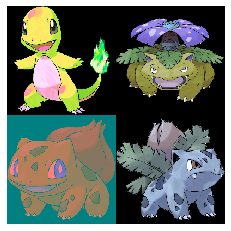

In [31]:
batch_augmented = batch_augmentor(batch)
_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in batch_augmented]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

In [32]:
def batch_augmentorx2(batch, operation1=None, operation2=None):
    options = list(range(len(operations)))
    if operation1 is None:
        rn = random.choice(options)
        print(operations[rn]())
        operation1 = operations[rn]()
    batch = np.array([do_operation(operation1, image) for image in batch])

    if operation2 is None:
        if rn in options:
            options.remove(rn)
        rn = random.choice(options)
        print(operations[rn]())
        operation2 = operations[rn]()
    return np.array([do_operation(operation2, image) for image in batch])

Zoom
Rotate 207


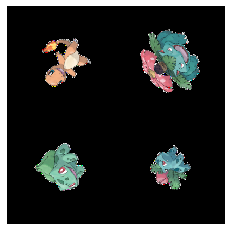

In [33]:
batch_augmented = batch_augmentorx2(batch)
_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in batch_augmented]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

Shear
Skew


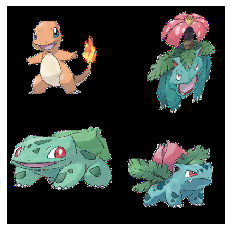

In [34]:
batch_augmented = batch_augmentorx2(batch)
_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in batch_augmented]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

Colorize
Skitch


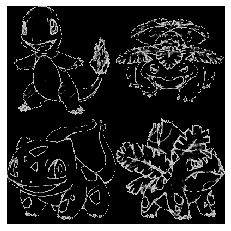

In [35]:
batch_augmented = batch_augmentorx2(batch)
_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in batch_augmented]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

Skew
Rotate 69


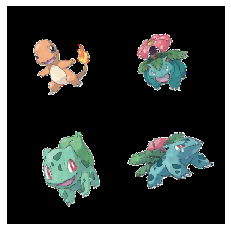

In [36]:
batch_augmented = batch_augmentorx2(batch)
_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in batch_augmented]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

In [37]:
def batch_augmentorx3(batch, operation1=None, operation2=None, operation3=None):
    options = list(range(len(operations)))
    if operation1 is None:
        rn = random.choice(options)
        print(operations[rn]())
        operation1 = operations[rn]()
    batch = np.array([do_operation(operation1, image) for image in batch])

    if operation2 is None:
        if rn in options:
            options.remove(rn)
        rn = random.choice(options)
        print(operations[rn]())
        operation2 = operations[rn]()
    batch = np.array([do_operation(operation2, image) for image in batch])

    if operation3 is None:
        if rn in options:
            options.remove(rn)
        rn = random.choice(options)
        print(operations[rn]())
        operation3 = operations[rn]()
    return np.array([do_operation(operation3, image) for image in batch])

Distort
Shear
Clone


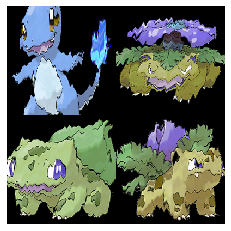

In [38]:
batch_augmented = batch_augmentorx3(batch)
_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in batch_augmented]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

Skitch
Shear
Distort


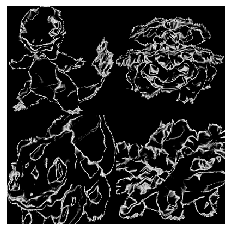

In [39]:
batch_augmented = batch_augmentorx3(batch)
_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in batch_augmented]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()

Skew
Flip
Colorize


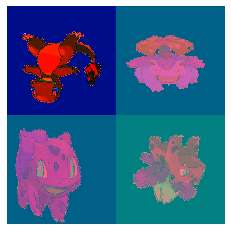

In [40]:
batch_augmented = batch_augmentorx3(batch)
_batch = [Image.fromarray((image*255).astype(np.uint8)) for image in batch_augmented]
img1 = append_images([_batch[0], _batch[1]], direction='horizontal')
img2 = append_images([_batch[2], _batch[3]], direction='horizontal')
final = append_images([img1, img2], direction='vertical')       
plt.imshow(final)
plt.axis('off');
plt.show()